# Задача: проверить (на группах 2, 3), корректна ли система сплитования

In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from tqdm.auto import tqdm

sns.set(font_scale=1.2)

In [2]:
connection = {
              'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20221120',
              'user':'student', 
              'password':'dpo_python_2020'
              }

In [3]:
query = """
SELECT 
  user_id,
  exp_group,
  sum(action = 'like') / sum(action = 'view') as CTR
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-10-26' and toDate(time) <= '2022-11-01' and exp_group in [2, 3] 
GROUP BY user_id, exp_group
"""

In [4]:
df = ph.read_clickhouse(query, connection=connection)

/Users/d.alekss/opt/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [5]:
df.head()

,user_id,exp_group,CTR
0,115383,3,0.305556
1,123580,3,0.163043
2,131473,2,0.175676
3,23985,2,0.181818
4,24523,2,0.141667


In [8]:
def aa_test(df, sample_size=500, n_exp = 10000, metric='CTR', gr1=2, gr2=3, alpha=0.05):
    
    p_val_list = []
    
    for _ in tqdm(range(n_exp)):
        sample_from_1 = df[df.exp_group == gr1]['{}'.format(metric)].sample(sample_size, replace = False).values
        sample_from_2 = df[df.exp_group == gr2]['{}'.format(metric)].sample(sample_size, replace = False).values
    
        p_value = pg.ttest(sample_from_1, sample_from_2)['p-val']['T-test']
        p_val_list.append(p_value)
    
    pv_df = pd.DataFrame({'p_value': p_val_list})
    
    sns.displot(pv_df.p_value, aspect=1.2, height=8)
    
    FPR = pv_df[pv_df.p_value < alpha].p_value.count() / pv_df.shape[0]
    
    print(f'FPR = {FPR}')
    
    if FPR <= alpha:
        print(f'Система слитования корректна, FPR меньше заданного уровня {alpha}')
    else:
        print(f'Система слитования некорректна, FPR больше заданного уровня {alpha}')
    

  0%|          | 0/10000 [00:00<?, ?it/s]

FPR = 0.0491
Система слитования корректна, FPR меньше заданного уровня 0.05


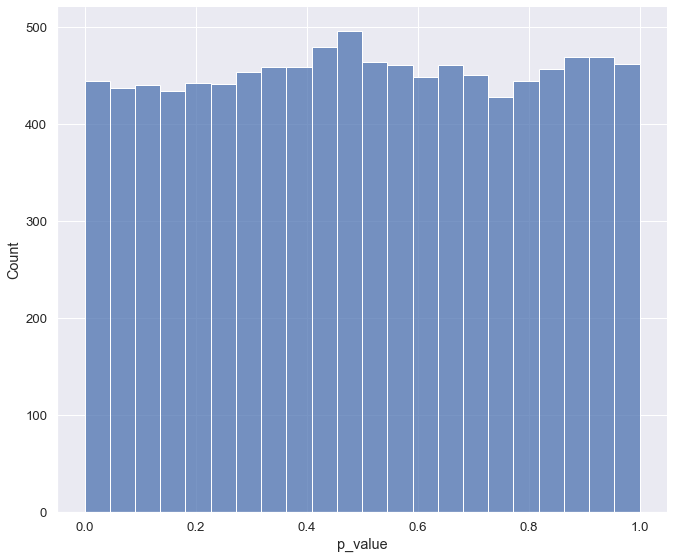

In [9]:
aa_test(df)